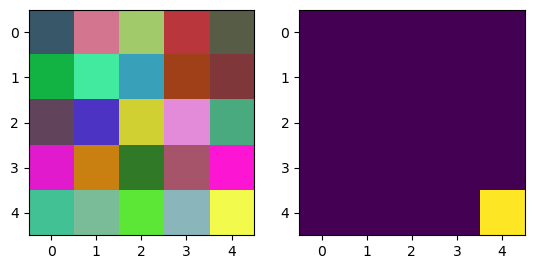

In [5]:
import numpy as np
import networkx as nx
from scipy.spatial.distance import euclidean

class SegmentationClass:
    def __init__(self):
        self.p0 = None
        self.x_a = None
        self.x_b = None
    
    def segmentImage(self, I):
        # Step 1: Constructing the Graph
        G = self.constructGraph(I)
        
        # Step 2: Ford-Fulkerson Algorithm
        self.fordFulkerson(G)
        
        # Step 3: Segmentation
        segmentation_mask = self.extractSegmentationMask(G, I.shape[:2])
        
        return segmentation_mask
    
    def constructAdjacencyMatrix(self, I):
        # Construct adjacency matrix based on input image I
        
        N = I.shape[0]
        M = I.shape[1]
        adjacency_matrix = np.zeros((N * M, N * M))

        for i in range(N):
            for j in range(M):
                for ni in range(max(0, i-1), min(N, i+2)):
                    for nj in range(max(0, j-1), min(M, j+2)):
                        if ni != i or nj != j:
                            pixel_i = i * M + j
                            pixel_ni = ni * M + nj
                            weight = self.calculatePixelWeight(I, (i, j), (ni, nj))
                            adjacency_matrix[pixel_i, pixel_ni] = weight

        return adjacency_matrix

    def constructGraph(self, I):
        # Initialize graph
        G = nx.DiGraph()

        # Add nodes and set weights
        for i in range(I.shape[0]):
            for j in range(I.shape[1]):
                pixel = i * I.shape[1] + j
                G.add_node(pixel)
                G.nodes[pixel]['b'] = self.calculateBackgroundLikelihood(I, (i, j))
                G.nodes[pixel]['a'] = self.calculateForegroundLikelihood(I, (i, j))

        # Add edges and set capacities
        adjacency_matrix = self.constructAdjacencyMatrix(I)
        for i in range(I.shape[0] * I.shape[1]):
            for j in range(I.shape[0] * I.shape[1]):
                if adjacency_matrix[i, j] > 0:
                    G.add_edge(i, j, capacity=self.p0)

        return G

    def fordFulkerson(self, G):
        # Ford-Fulkerson Algorithm
        while True:
            # Find augmenting path using BFS
            path = self.findAugmentingPath(G)
            if path is None:
                break

            # Update flow along the augmenting path
            bottleneck_capacity = min(G.get_edge_data(i, j)['capacity'] for i, j in zip(path, path[1:]))
            for i, j in zip(path, path[1:]):
                G.get_edge_data(i, j)['capacity'] -= bottleneck_capacity
                G.get_edge_data(j, i)['capacity'] += bottleneck_capacity

    def findAugmentingPath(self, G):
        # Find augmenting path using BFS
        source = 0
        target = G.number_of_nodes() - 1
        visited = set()
        queue = [[source]]

        while queue:
            path = queue.pop(0)
            node = path[-1]

            if node in visited:
                continue

            for neighbor in G.neighbors(node):
                residual_capacity = G.get_edge_data(node, neighbor)['capacity']
                if residual_capacity > 0:
                    new_path = list(path)
                    new_path.append(neighbor)
                    queue.append(new_path)

                    if neighbor == target:
                        return new_path

            visited.add(node)

        return None

    def extractSegmentationMask(self, G, shape):
        # Extract segmentation mask from the final state of the graph
        segmentation_mask = np.zeros(shape + (1,), dtype=np.uint8)

        for i in range(shape[0]):
            for j in range(shape[1]):
                pixel = i * shape[1] + j
                if nx.has_path(G, pixel, G.number_of_nodes() - 1):
                    segmentation_mask[i, j] = 1

        return segmentation_mask

    def calculatePixelWeight(self, I, x_i, x_j):
        # Calculate pixel weight between neighboring pixels
        distance = euclidean(I[x_i], I[x_j])
        if distance < 2:
            return self.p0
        else:
            return 0

    def calculateForegroundLikelihood(self, I, x):
        # Calculate likelihood of the pixel being foreground
        x_a = self.x_a
        pixel_value_x = I[x[0], x[1]]
        pixel_value_x_a = I[x_a[0], x_a[1]]
        return 442 - round(euclidean(pixel_value_x, pixel_value_x_a))

    def calculateBackgroundLikelihood(self, I, x):
    # Calculate likelihood of the pixel being background
        x_b = self.x_b
        pixel_value_x = I[x[0], x[1]]
        pixel_value_x_b = I[x_b[0], x_b[1]]
        return 442 - round(euclidean(pixel_value_x, pixel_value_x_b))

# Example usage:
obj = SegmentationClass()
obj.p0 = 5
obj.x_a = np.array([0, 1])
obj.x_b = np.array([2, 3])

# Replace 'image_path' with the actual path to your image
image_path = 'path_to_your_image.jpg'
# I = np.array(Image.open(image_path))
I = np.random.randint(0, 256, (5, 5, 3))  # Example image

segmentation_mask = obj.segmentImage(I)

# show the image and segmentation mask
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(I)
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask)
plt.show()